---
title: "Modelling protein detectability with an MLP"

date: last-modified

author:

- name: Eric Deutsch

  orcid: 0000-0001-8732-0928

  affiliations:
    - Institute for Systems Biology, Seattle WA, USA

---

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ProteomicsML/ProteomicsML/blob/main/tutorials/proteinvisibility/_modeling-protein-detectability.ipynb)


# Introduction

When subjecting whole cell lysates to mass spectrometry-based proteomics analysis, some proteins are easily detected while others are not seen. The proteins that are never detected are often colloquially called the dark proteome. There are many reasons for not detecting proteins. Some proteins may only be found in certain cell types or in certain developmental stages. Comprehensive accumulation of datasets from different cell types and developmental stages can overcome this limitation. Other reasons such as the physicochemical properties of the proteins may hinder detection. Here we explore the "light and dark proteome" based on proteins that are observed and not observed in the Arabidopsis PeptideAtlas, which has been assembled by search over 200 million MS/MS spectra from 100 different datasets. 

First we import some needed libraries

In [ ]:
!pip install numpy, pandas, matplotlib, sklearn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

Read input data and extract the columns to train on. We will attempt to train on the protein molecular weight, protein physicochemical properties gravy score (a measure of hydrophobicity), isoelectric point (pI), and then two metrics from RNA-seq analysis: the percentage of RNA-seq experiments that detect a transcript for the given protein, and the highest TPM (transcripts per million, i.e. abundance) in any one dataset.

In [3]:
proteins = pd.read_csv('http://www.peptideatlas.org/builds/arabidopsis/light_and_dark_protein_list.tsv', sep="\t")
learning_values = proteins[ ['molecular_weight', 'gravy', 'pI', 'rna_detected_percent', 'highest_tpm' ] ].copy()

Normalize the data to have ranges like 0 to 1

In [4]:
learning_values.loc[ :, 'molecular_weight'] = learning_values['molecular_weight'] / 100
learning_values.loc[ learning_values[ 'molecular_weight'] > 1, 'molecular_weight'] = 1.0
learning_values.loc[ :, 'gravy'] = ( learning_values['gravy'] + 2 ) / 4
learning_values.loc[ :, 'pI'] = ( learning_values['pI'] - 4 ) / 8

learning_values.loc[ :, 'rna_detected_percent'] = learning_values['rna_detected_percent'] / 100
learning_values.loc[ :, 'highest_tpm'] = learning_values['highest_tpm'] / 300
learning_values.loc[ learning_values[ 'highest_tpm'] > 1, 'highest_tpm'] = 1.0

Set the classifications to 0 and 1

In [5]:
classes = proteins['status'].copy()
classes[ classes == 'canonical' ] = 1
classes[ classes == 'not observed' ] = 0

Split into 75% train and 25% test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(learning_values, classes, test_size=0.25)

Train the classifier on the training set

In [7]:
clf = MLPClassifier(solver='lbfgs', max_iter=1000, hidden_layer_sizes=(100,), alpha=1e-4, random_state=1)
clf.fit(X_train, list(y_train))

C:\Program Files\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(max_iter=1000, random_state=1, solver='lbfgs')

Predict for all the test set

In [8]:
predictions = clf.predict(X_test)
probabilities = clf.predict_proba(X_test)

Make a ROC curve

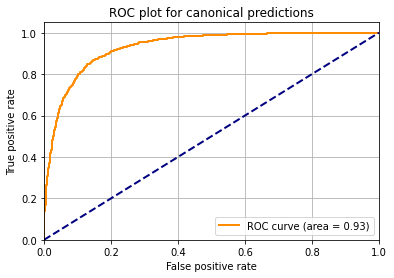

In [9]:
probabilities_list = list(probabilities[ :, 1])
fpr, tpr, thresholds = roc_curve(np.ravel(list(y_test)), np.ravel(probabilities_list))
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr,tpr,color="darkorange",lw=2,label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC plot for canonical predictions")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Predict for all protein and write out the table with learned results

In [10]:
probabilities = clf.predict_proba(learning_values)
proteins['learned_canonical_prob'] = probabilities[ :, 1]
proteins.to_csv('light_and_dark_protein_list_trained.tsv', sep="\t", index=False)